In [1]:
import os, sys
import gitpath
HOME_PATH = gitpath.root()
sys.path.append(HOME_PATH)

import pickle

import numpy as np

# Import pytorch dependencies
import torch
from torch.utils.data import DataLoader

# Import toolkits
from utils.visualization_3D_objects import *

from nn.pointnetae import *
from nn.gf_vae import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
DATASET = 'shapenet'
CATEGORY = 'car'
DATA_PATH = os.path.join(HOME_PATH, "data/preprocessed", DATASET, CATEGORY)
CHECKPOINT_FOLDER = os.path.join(HOME_PATH, "saved_nn")
MODEL_TYPE = "global_feat_VAE_car"
POINTNET_NAME = "PointNetAE_car"

### Import Preprocessed ModelNet40 cars (Run shapenet_preprocessing.ipynb first to get these data)

In [3]:
BATCH_SIZE = 16
global_feat = np.loadtxt("global_feat.csv", delimiter=",", dtype=float)
data_loader = DataLoader(
    global_feat, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4,
    drop_last=True
)

### Load saved model

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")
    
model_test = VAE()
state_dict = torch.load(os.path.join(CHECKPOINT_FOLDER, MODEL_TYPE + '.pth')) # change the path to your own checkpoint file
model_test.cuda()
model_test.load_state_dict(state_dict['state_dict'])
model_test.eval()

print(state_dict['epoch'])

Run on GPU...
340


In [5]:
pointnetae = PointNet_AE(3, 2048)
state_dict = torch.load(os.path.join(CHECKPOINT_FOLDER, POINTNET_NAME + '.pth')) # change the path to your own checkpoint file
pointnetae.cuda()
pointnetae.load_state_dict(state_dict['state_dict'])
pointnetae.eval()

print(state_dict['epoch'])

184


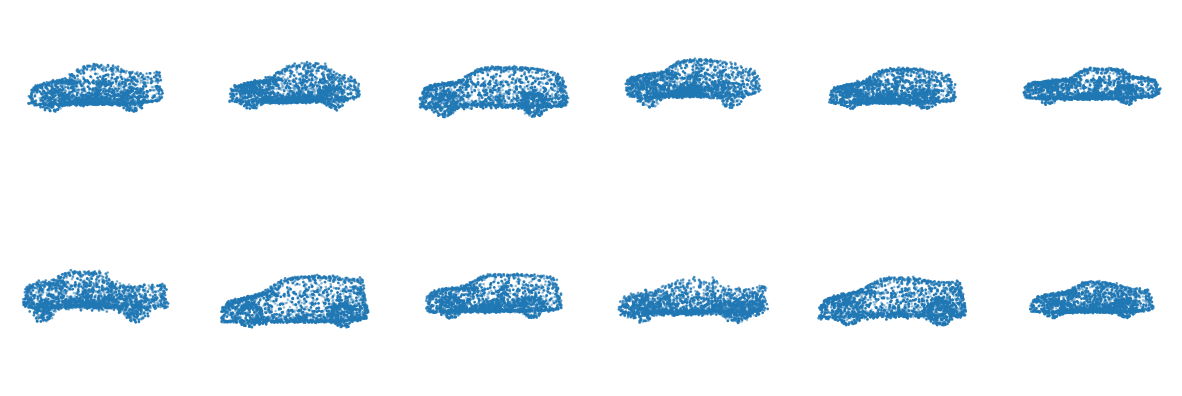

In [41]:
X_sample = pointnetae.decoder(model_test.decoder(torch.randn(12, 128).cuda())).cpu().detach().numpy()

fig = plt.figure(figsize=(15,5))

# Get the test data

# Plot the data
for i, X in enumerate(X_sample):
    x, y, z = X[0], X[1], X[2]
    ax = fig.add_subplot(2, 6, i + 1, projection='3d')
    ax.scatter(x, y, z, s = 1)
    ax.view_init(-90, 90)

    l_bound = np.min(x)+2; u_bound = np.max(x)-2
    # l_bound = -5; u_bound = 5
    ax.set_xlim(l_bound, u_bound)
    ax.set_ylim(l_bound, u_bound)
    ax.set_zlim(l_bound, u_bound)
    ax.axis('off')

plt.savefig(os.path.join(HOME_PATH, "images","random_sample.png"))

In [6]:
X_sample = pointnetae.decoder(model_test.decoder(torch.randn(12, 128).cuda())).cpu().detach().numpy()
fig = draw3DPoints(X_sample[0], title = "Sampled " + CATEGORY)
fig.show()

In [7]:
def extractGlobalFeatForAllData(data_loader, model_test, device):
    latent_vectors_lst = []
    for batch_idx, (inputs) in enumerate(data_loader):
        # copy inputs to device
        inputs = inputs.float().to(device)
        # compute the output and loss
        outputs, latent_vectors_i = model_test(inputs)
        latent_vectors_lst.append(latent_vectors_i.cpu().detach().numpy())
        
    latent_vectors = np.vstack(latent_vectors_lst)
    return latent_vectors

latent_vectors = extractGlobalFeatForAllData(data_loader, model_test, device)
print(np.mean(np.mean(latent_vectors)), np.mean(np.var(latent_vectors)))

-0.0008488156 1.0090064


[ 13  79  38  94  84  39  16  31 115 122 117  22  29  28   0  78  85  93
  68 109  32  35  97  64  45  48  51  90  62   2  17  72  14  74  66 101
  67  12  18 123  26 120 121  41 116  52  89  36  43 102  24  83   4  15
  92 125  56  77  49  20  80  30 124  70  10 127 112   8  58  61  46  55
  40  88  47  71  57  27 111  23  82  69  65   6  53  86 118 110   1  50
 100   9  76  34  75 104  19 113   3 126  81 103  60  73  25  21  91  42
 105   7  11  37 106  96  98 119  87 108   5  54  95  63 107 114  33  99
  59  44]


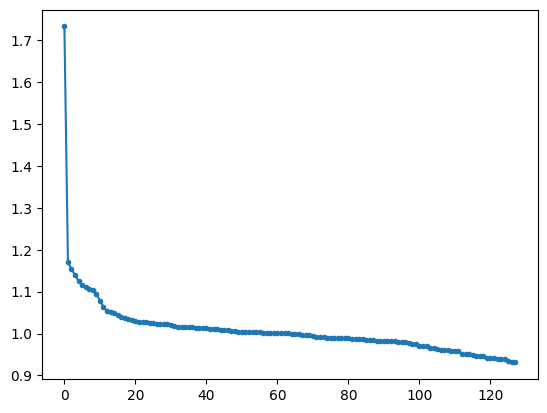

In [37]:
def computeAllDataTopK(latent_vectors, model_test, top_k = 10, mod_range = 2.5, n_step = 20):

    mu, var = np.mean(latent_vectors, axis = 0), np.var(latent_vectors, axis = 0)
    sigificant_feature_idx = np.argsort(var)[::-1]

    print(sigificant_feature_idx)
    plt.clf
    plt.plot(var[sigificant_feature_idx], '.-')
    plt.axis('tight')

    X_list = dict()
    for idx in sigificant_feature_idx[:top_k]:
        X_feat_list = []
        lower_bound = mu[idx] - var[idx] * mod_range
        higher_bound = mu[idx] + var[idx] * mod_range
        for step in np.linspace(lower_bound, higher_bound, n_step):
            new_features = torch.from_numpy(latent_vectors).float().cuda()
            new_features[:, idx] = step
            X = pointnetae.decoder(model_test.decoder(new_features)).cpu().detach().numpy()
            X_feat_list.append(X)

        X_feat_list = np.asarray(X_feat_list)
        X_list[idx] = X_feat_list

    return X_list, sigificant_feature_idx

X_list, sigificant_feature_idx = computeAllDataTopK(latent_vectors, model_test)

In [40]:
idx = 0
obj_idx = 1
fig = draw3DpointsSlider(X_list[sigificant_feature_idx[idx]], sigificant_feature_idx[idx], obj_idx)